In [94]:
import importlib
import power_net
importlib.reload(power_net)

<module 'power_net' from 'c:\\Users\\janav\\Documents\\load forecasting\\local-stlf\\powernet\\power_net.py'>

In [109]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from power_net import PowerNet
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [132]:
def create_calendar_features(df, timestamp_col='ts'):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df.set_index(timestamp_col, inplace=True)
    # Resample to hourly and interpolate
    df = df.resample('h').mean()
    df = df.interpolate(method='time', limit_direction='both')
    df.index.name = timestamp_col
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.weekday
    df['hour_of_day'] = df.index.hour
    df['period_of_day'] = df['hour_of_day'].apply(lambda h: 1 if 6 <= h < 18 else 0)
    df['is_weekend'] = df['day_of_week'].apply(lambda d: 1 if d >= 5 else 0)
    return df.reset_index()

def preprocess_weather_data(path, missing_threshold=0.15):
    df = pd.read_csv(path, parse_dates=['time'])
    df.set_index('time', inplace=True)
    # Ensure complete hourly range
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
    df = df.reindex(full_range)
    df.index.name = 'time'
    missing_ratio = df.isna().mean()
    df = df.drop(columns=missing_ratio[missing_ratio > missing_threshold].index.tolist())
    df = df.interpolate(method='time', limit_direction='both')
    return df

def join_calendar_and_weather(load_df, weather_df, timestamp_col='ts'):
    load_df[timestamp_col] = pd.to_datetime(load_df[timestamp_col])
    load_df = load_df.set_index(timestamp_col)
    merged_df = load_df.join(weather_df, how='inner')
    return merged_df.reset_index().rename(columns={'index': 'ts'})

def prepare_powernet_data(df, target_col='vrednost', timestamp_col='ts', test_size=0.2, val_size=0.1):
    df = df.drop(columns=[timestamp_col])
    y = df[[target_col]].copy()
    X = df.drop(columns=[target_col])
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_ratio, shuffle=False)

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    y_train_scaled = target_scaler.fit_transform(y_train)
    X_val_scaled = feature_scaler.transform(X_val)
    y_val_scaled = target_scaler.transform(y_val)
    X_test_scaled = feature_scaler.transform(X_test)
    y_test_scaled = target_scaler.transform(y_test)

    print(f"Total samples: {len(df)} | Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

    return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, feature_scaler, target_scaler



def prepare_powernet_data(df, target_col='vrednost', timestamp_col='ts', test_size=0.2, val_size=0.1):
    df = df.drop(columns=[timestamp_col])
    y = df[[target_col]].copy()
    X = df.drop(columns=[target_col])
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_ratio, shuffle=False)

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    y_train_scaled = target_scaler.fit_transform(y_train)
    X_val_scaled = feature_scaler.transform(X_val)
    y_val_scaled = target_scaler.transform(y_val)
    X_test_scaled = feature_scaler.transform(X_test)
    y_test_scaled = target_scaler.transform(y_test)

    return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, feature_scaler, target_scaler

def build_sequence_data(X, y, lookback):
    seq_x, meta_x, targets = [], [], []
    for i in range(lookback, len(X)):
        seq_x.append(X[i - lookback:i, 0:1])  # univariate series input
        meta_x.append(X[i, 1:])               # static meta features (if any)
        targets.append(y[i])
    return (
        torch.tensor(seq_x, dtype=torch.float32),
        torch.tensor(meta_x, dtype=torch.float32),
        torch.tensor(targets, dtype=torch.float32)
    )

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


def train_powernet(model, train_loader, val_loader, epochs=100, lr=1e-3, device='cuda', patience=10):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    early_stopper = EarlyStopping(patience=patience)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for seq_x, meta_x, y in train_loader:
            seq_x, meta_x, y = seq_x.to(device), meta_x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(seq_x, meta_x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seq_x, meta_x, y in val_loader:
                seq_x, meta_x, y = seq_x.to(device), meta_x.to(device), y.to(device)
                preds = model(seq_x, meta_x)
                val_loss += criterion(preds, y).item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch:02d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        early_stopper(avg_val_loss)
        if early_stopper.early_stop:
            print("⏹️ Early stopping triggered.")
            break

def search_powernet_hyperparams(train_loader, val_loader, input_size_lstm, input_size_meta, horizon):
    if input_size_meta <= 0:
        raise ValueError(f"Invalid input_size_meta={input_size_meta}. Must be positive.")

    # lstm_hidden_options = [64, 128, 256, 512]
    # mlp_hidden1_options = [32, 64]
    # mlp_hidden2_options = [16, 32]
    # final_hidden_options = [32, 64]
    # dropout_options = [0.2, 0.3]
    # lr_options = [1e-3, 5e-4]

    lstm_hidden_options = [64]
    mlp_hidden1_options = [32]
    mlp_hidden2_options = [16]
    final_hidden_options = [512]
    dropout_options = [0.2]
    lr_options = [1e-3, 5e-4]
    epochs = 100

    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    for lstm_h, mlp_h1, mlp_h2, final_h, dropout, lr in product(
        lstm_hidden_options,
        mlp_hidden1_options,
        mlp_hidden2_options,
        final_hidden_options,
        dropout_options,
        lr_options
    ):
        print(f"\n🔧 Trying config: LSTM={lstm_h}, MLP1={mlp_h1}, MLP2={mlp_h2}, FINAL={final_h}, dropout={dropout}, lr={lr}")

        model = PowerNet(
            input_size_meta=input_size_meta,
            horizon=horizon,
            input_size_lstm=input_size_lstm,
            lstm_hidden=lstm_h,
            lstm_layers=2,
            mlp_hidden1=mlp_h1,
            mlp_hidden2=mlp_h2,
            final_hidden=final_h,
            dropout=dropout
        )

        train_powernet(model, train_loader, val_loader, epochs=epochs, lr=lr, device=DEVICE)

        model.eval()
        total_val_loss = 0
        criterion = nn.MSELoss()
        with torch.no_grad():
            for seq_x, meta_x, y in val_loader:
                seq_x, meta_x, y = seq_x.to(DEVICE), meta_x.to(DEVICE), y.to(DEVICE)
                preds = model(seq_x, meta_x)
                total_val_loss += criterion(preds, y).item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"📉 Validation Loss: {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model
            best_params = {
                'lstm_hidden': lstm_h,
                'mlp_hidden1': mlp_h1,
                'mlp_hidden2': mlp_h2,
                'final_hidden': final_h,
                'dropout': dropout,
                'lr': lr
            }

    print("\n🏆 Best config found:")
    print(best_params)
    return best_model, best_params

In [137]:
data = create_calendar_features(pd.read_csv('mm79158.csv'), 'ts')
wdf = preprocess_weather_data('slovenia_weather_averaged.csv')
df = join_calendar_and_weather(data, wdf, 'ts')

X_train, y_train, X_val, y_val, X_test, y_test, feature_scaler, target_scaler = prepare_powernet_data(df, test_size=0.3, val_size=0.1)

In [138]:
df.shape, X_train.shape

((30241, 7), (18143, 5))

In [139]:
lookback = 96
horizon = 2

seq_train, meta_train, y_train = build_sequence_data(X_train, y_train, lookback)
seq_val, meta_val, y_val = build_sequence_data(X_val, y_val, lookback)

train_loader = DataLoader(TensorDataset(seq_train, meta_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(seq_val, meta_val, y_val), batch_size=64)

input_size_lstm = seq_train.shape[2]   # this is 1 for univariate
input_size_meta = meta_train.shape[1]  # this is correct size of meta features

In [140]:
best_model, best_config = search_powernet_hyperparams(train_loader, val_loader, input_size_lstm, input_size_meta, horizon)


🔧 Trying config: LSTM=64, MLP1=32, MLP2=16, FINAL=512, dropout=0.2, lr=0.001


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([63, 1])) that is different to the input size (torch.Size([63, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([49, 1])) that is different to the input size (torch.Size([49, 2])). This will likely lead to incorrect results

Epoch 01/100 | Train Loss: 0.0187 | Val Loss: 0.0185
Epoch 02/100 | Train Loss: 0.0180 | Val Loss: 0.0191
Epoch 03/100 | Train Loss: 0.0179 | Val Loss: 0.0201
Epoch 04/100 | Train Loss: 0.0177 | Val Loss: 0.0199
Epoch 05/100 | Train Loss: 0.0175 | Val Loss: 0.0195
Epoch 06/100 | Train Loss: 0.0173 | Val Loss: 0.0179
Epoch 07/100 | Train Loss: 0.0172 | Val Loss: 0.0167
Epoch 08/100 | Train Loss: 0.0170 | Val Loss: 0.0174
Epoch 09/100 | Train Loss: 0.0169 | Val Loss: 0.0163
Epoch 10/100 | Train Loss: 0.0169 | Val Loss: 0.0166
Epoch 11/100 | Train Loss: 0.0167 | Val Loss: 0.0186
Epoch 12/100 | Train Loss: 0.0167 | Val Loss: 0.0185
Epoch 13/100 | Train Loss: 0.0166 | Val Loss: 0.0170
Epoch 14/100 | Train Loss: 0.0166 | Val Loss: 0.0175
Epoch 15/100 | Train Loss: 0.0166 | Val Loss: 0.0156
Epoch 16/100 | Train Loss: 0.0165 | Val Loss: 0.0180
Epoch 17/100 | Train Loss: 0.0165 | Val Loss: 0.0159
Epoch 18/100 | Train Loss: 0.0165 | Val Loss: 0.0154
Epoch 19/100 | Train Loss: 0.0165 | Val Loss: 

In [105]:
torch.save(best_model.state_dict(), "model_weights.pth")

In [141]:
device='cuda'
best_model.eval()
step = horizon
preds = []
true_vals = []

for i in range(0, len(X_test) - lookback - horizon + 1, step):
    seq_x = torch.tensor(X_test[i:i+lookback, :1], dtype=torch.float32).unsqueeze(0).to(device)
    meta_x = torch.tensor(X_test[i+lookback-1, 1:], dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = best_model(seq_x, meta_x).cpu().numpy().flatten()

    preds.append(pred)  # shape: (horizon,)
    true_vals.append(y_test[i+lookback:i+lookback+horizon, 0])  # shape: (horizon,)

# Convert to arrays
preds = np.concatenate(preds).reshape(-1, 1)
true_vals = np.concatenate(true_vals).reshape(-1, 1)

# Rescale
preds_rescaled = target_scaler.inverse_transform(preds)
true_rescaled = target_scaler.inverse_transform(true_vals)


In [142]:
mae = mean_absolute_error(true_rescaled, preds_rescaled)
mse = mean_squared_error(true_rescaled, preds_rescaled)
mape = mean_absolute_percentage_error(true_rescaled, preds_rescaled)


print("\n📊 Final Flattened Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"MAPE: {mape:.2%}")


📊 Final Flattened Evaluation:
MAE:  1.4704
MSE:  3.6811
MAPE: 143.02%


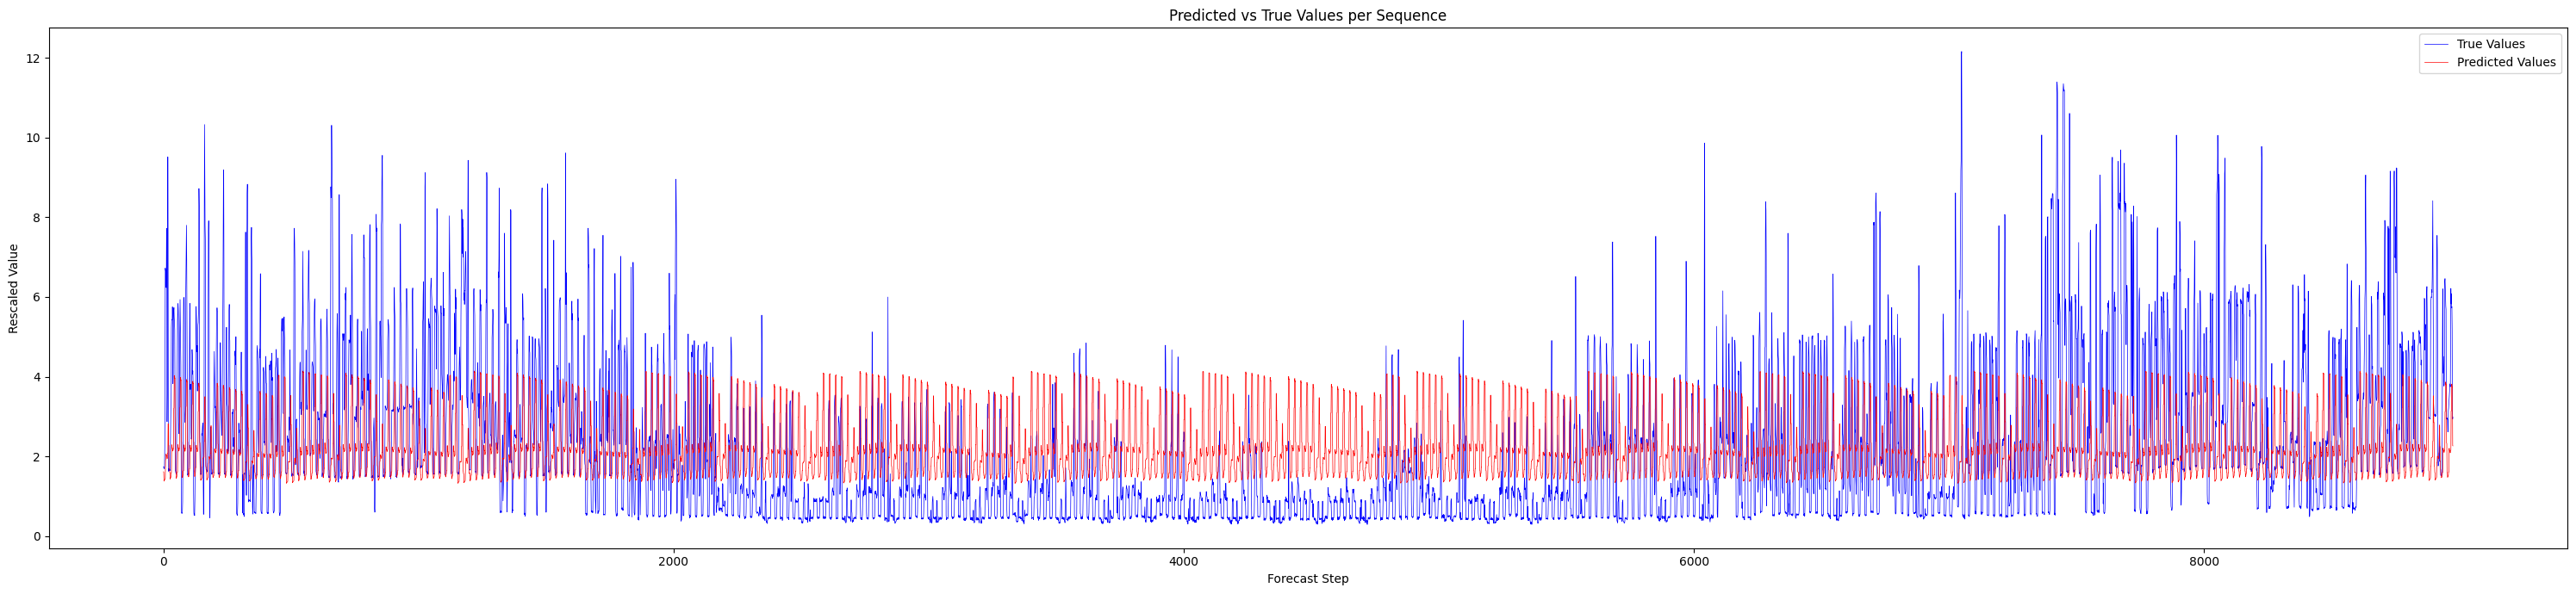

In [143]:
plt.figure(figsize=(30, 7))
plt.plot(true_rescaled, color='blue', linewidth=0.5, label='True Values')
plt.plot(preds_rescaled, color='red', linewidth=0.5, label='Predicted Values')
plt.title("Predicted vs True Values per Sequence")
plt.xlabel("Forecast Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()